In [1]:
!pip install tensorflow
!pip install keras

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

# Set path
filename = '/content/drive/MyDrive/Canada'

# Automatically find class names from 'train' folder
classes = os.listdir(os.path.join(filename, 'train'))
print("Classes:", classes)

# Label encoder
lb = LabelEncoder()
lb.fit(classes)  # Fit once, use consistently

# Function to load dataset
def load_dataset(split):
    X = []
    y = []
    for class_name in classes:
        path = os.path.join(filename, split, class_name)
        for img_name in tqdm(os.listdir(path), desc=f'Loading {split}/{class_name}'):
            img = cv2.imread(os.path.join(path, img_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (28, 28))
            img = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            X.append(img)
            y.append(class_name)
    X = np.array(X).reshape(-1, 28, 28, 1)
    y = lb.transform(y)
    return X, y

# Load all sets
X_train, y_train = load_dataset('train')
X_valid, y_valid = load_dataset('valid')
X_test, y_test = load_dataset('test')

print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)
print("Test:", X_test.shape, y_test.shape)


Classes: ['wildfire', 'nowildfire']


Loading test/nowildfire: 100%|██████████| 2871/2871 [01:20<00:00, 35.71it/s] 

Train: (30430, 28, 28, 1) (30430,)
Valid: (6320, 28, 28, 1) (6320,)
Test: (6411, 28, 28, 1) (6411,)


In [38]:
# Define input shape
input_shape = (28, 28, 1)
inputs = tf.keras.Input(shape=input_shape)

# Block 1
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

# Block 2
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten and Dense layers
x = layers.Flatten(name='feature_layer')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(classes), activation='softmax')(x)

# Define model
model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Train the model
history = model.fit(
    X_train, y_train,
    epochs=40,
    validation_data=(X_valid, y_valid),

)


# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')


Epoch 1/40
951/951 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6216 - loss: 0.6353 - val_accuracy: 0.7717 - val_loss: 0.4786
Epoch 2/40
951/951 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7502 - loss: 0.5238 - val_accuracy: 0.7918 - val_loss: 0.4561
Epoch 3/40
951/951 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7808 - loss: 0.4832 - val_accuracy: 0.8016 - val_loss: 0.4323
Epoch 4/40
951/951 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7969 - loss: 0.4564 - val_accuracy: 0.7959 - val_loss: 0.4455
Epoch 5/40
951/951 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8009 - loss: 0.4464 - val_accuracy: 0.8106 - val_loss: 0.4204
Epoch 6/40
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8133 - loss: 0.4267 - val_accuracy: 0.8231 - val_loss: 0.3931
Epoch 7/40
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8124 - loss: 0.4228 - val_accuracy: 0.8242 - val_loss: 0.3981
Epoch 8/40
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8154 - loss: 0.4149 - val_accuracy: 0

In [36]:
# Final Training Accuracy from last epoch
final_train_acc = history.history['accuracy'][-1]

# Final Validation Accuracy from last epoch
final_val_acc = history.history['val_accuracy'][-1]

# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# Print all results
print("✅ Final Results:")
print(f"Final Training Accuracy:    {final_train_acc:.4f}")
print(f"Final Validation Accuracy:  {final_val_acc:.4f}")
print(f"Final Test Accuracy:        {test_acc:.4f}")


✅ Final Results:
Final Training Accuracy:    0.8679
Final Validation Accuracy:  0.8351
Final Test Accuracy:        0.8456


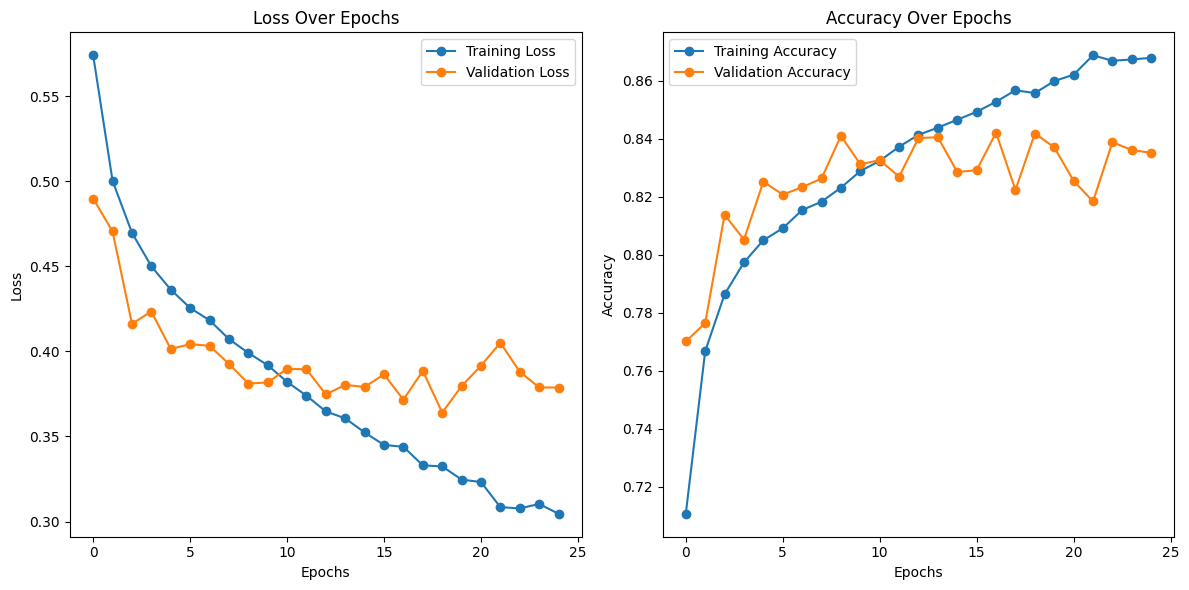

In [37]:
# Plot Training & Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

Epoch 1/25
476/476 - 59s - 124ms/step - accuracy: 0.7294 - loss: 0.5957 - val_accuracy: 0.5590 - val_loss: 5.7370 - learning_rate: 1.0000e-03
Epoch 2/25
476/476 - 82s - 171ms/step - accuracy: 0.7865 - loss: 0.4642 - val_accuracy: 0.6872 - val_loss: 0.6428 - learning_rate: 1.0000e-03
Epoch 3/25
476/476 - 56s - 118ms/step - accuracy: 0.8032 - loss: 0.4374 - val_accuracy: 0.7453 - val_loss: 0.5236 - learning_rate: 1.0000e-03
Epoch 4/25
476/476 - 82s - 172ms/step - accuracy: 0.8151 - loss: 0.4156 - val_accuracy: 0.5915 - val_loss: 0.9743 - learning_rate: 1.0000e-03
Epoch 5/25
476/476 - 83s - 175ms/step - accuracy: 0.8244 - loss: 0.3991 - val_accuracy: 0.6396 - val_loss: 0.6710 - learning_rate: 1.0000e-03
Epoch 6/25
476/476 - 54s - 113ms/step - accuracy: 0.8335 - loss: 0.3813 - val_accuracy: 0.8407 - val_loss: 0.3691 - learning_rate: 1.0000e-03
Epoch 7/25
476/476 - 55s - 115ms/step - accuracy: 0.8439 - loss: 0.3662 - val_accuracy: 0.7372 - val_loss: 0.5656 - learning_rate: 1.0000e-03
Epoch 

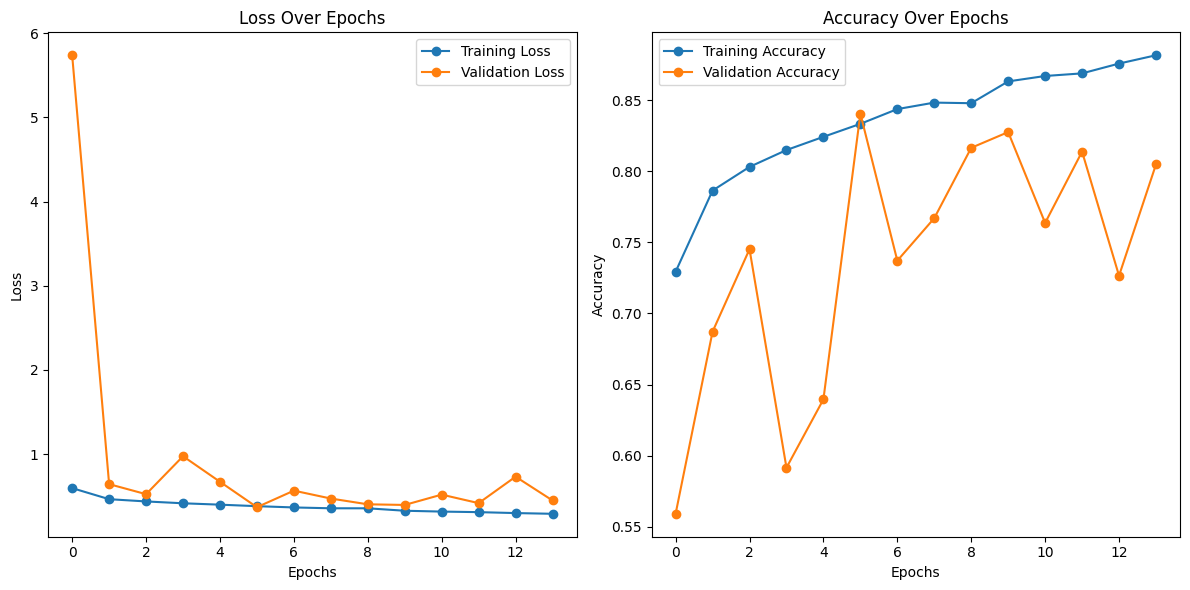

In [6]:
# Modified
from tensorflow.keras import layers, models, callbacks

# Define input shape
input_shape = (28, 28, 1)
inputs = tf.keras.Input(shape=input_shape)

# Block 1
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Block 2
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Flatten and Dense layers
x = layers.Flatten(name='feature_layer')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(len(classes), activation='softmax')(x)

# Define model
model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1
)
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True, verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=64,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler, early_stop],
    verbose=2
)

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

# Final Training Accuracy from last epoch
final_train_acc = history.history['accuracy'][-1]

# Final Validation Accuracy from last epoch
final_val_acc = history.history['val_accuracy'][-1]

# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# Print all results
print("✅ Final Results:")
print(f"Final Training Accuracy:    {final_train_acc:.4f}")
print(f"Final Validation Accuracy:  {final_val_acc:.4f}")
print(f"Final Test Accuracy:        {test_acc:.4f}")


# Plot Training & Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()